<a href="https://colab.research.google.com/github/mrbrownnn/smart_traffic_lights/blob/backup_pre_clean/teacher_knowledge_distillation_model_v11l.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train Teacher Model (YOLOv11-L) for Knowledge Distillation
This step trains a high-capacity teacher model (YOLOv11-L) that will later be used to guide a smaller student model through Knowledge Distillation (KD). The teacher model should achieve strong feature representation and high mAP, because the quality of the distilled student model depends on how well the teacher has learned.

Key Goals:

- Achieve high mAP50 and mAP50-95

- Ensure the model converges fully (no early stop plateau)

- Produce a stable and generalizable checkpoint (best.pt) to be used for KD

Training Notes:

best.pt selected based on validation performance, not final epoch
Epochs: 100 depending on dataset complexity (100 random picture in more than 3000 multi-traffic-view picture)

After training completes, we will proceed to:

Distillation Round 1: YOLOv11-L → YOLOv11-N

Optional Compression: Pruning + Ghost layers + INT8 Quantization for deployment on Raspberry Pi 4

Distillation Round 2: Optional Compression + new YOLOv11-L with new training dataset- improve mAP

Goals: mAP YOLOv11n ~ 3-6% YOLOv11l

Author by: mrbrownnn

In [ ]:
!nvidia-smi
!pip install ultralytics==8.3.213
!pip install roboflow
!pip install ultralytics==8.3.213 matplotlib seaborn
!nvidia-smi
import matplotlib.pyplot as plt
import seaborn as sns

# prepare model

Thu Nov 13 20:48:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Derection dataset_folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATASET_DIR = "/content/drive/MyDrive/visdrone_dataset/converted_yolo_visdrone/data_set_full"
PROJECT_DIR = "/content/drive/MyDrive/yolo_traffic_teacher_v11_v2"

!mkdir -p {PROJECT_DIR}
%cd {PROJECT_DIR}


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/yolo_traffic_teacher_v11_v2


In [ ]:
from ultralytics import YOLO
# Load model YOLOv11 large
model = YOLO('yolo11l.pt')
model.info()
model = YOLO('yolo11l.pt')
#training func
results = model.train(
    data=f"{DATASET_DIR}/data_vis.yaml",
    epochs=60,
    imgsz=640,
    batch=16,
    device=0,             # GPU
    workers=2,            # ít luồng hơn giúp giảm I/O bottleneck
    cache=True,
    amp=True,
    cos_lr=True,
    patience=15,          # early stop nếu val không cải thiện
    project=PROJECT_DIR,
    name="yolo11l_optimized"
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
YOLO11l summary: 357 layers, 25,372,160 parameters, 0 gradients, 87.6 GFLOPs
New https://pypi.org/project/ultralytics/8.3.228 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.213 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/drive/MyDrive/visdrone_dataset/converted_yolo_visdrone/data_set_full/data_vis.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, 

KeyboardInterrupt: 

In [ ]:
import os
os._exit(0)

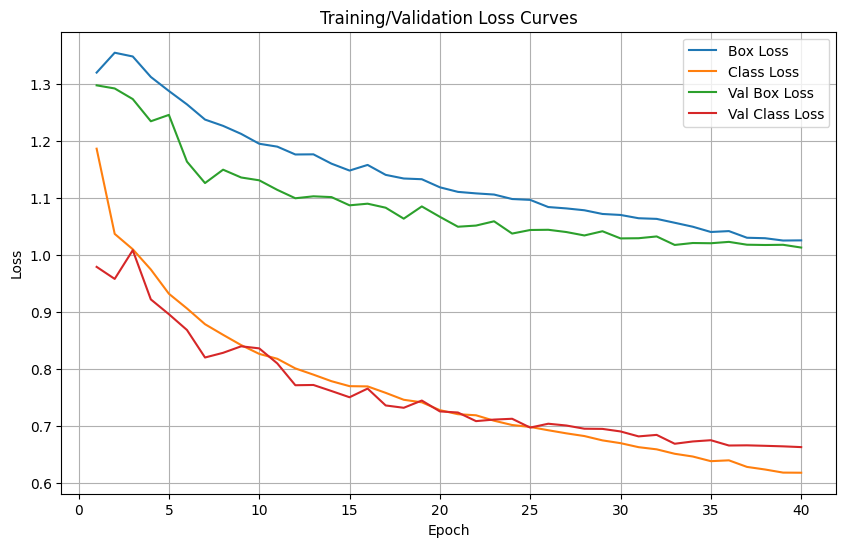

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load training results CSV
metrics_path = f"{PROJECT_DIR}/yolo11l_optimized5/results.csv"
df = pd.read_csv(metrics_path)

plt.figure(figsize=(10,6))
plt.plot(df['epoch'], df['train/box_loss'], label='Box Loss')
plt.plot(df['epoch'], df['train/cls_loss'], label='Class Loss')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training/Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

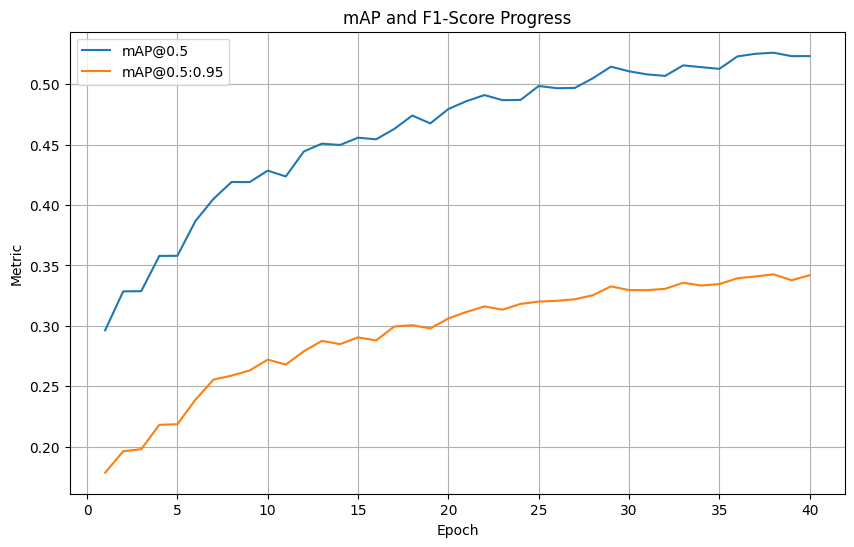

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
# plt.plot(df['epoch'], df['metrics/F1(B)'], label='F1 Score') # This line caused the error.
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('mAP and F1-Score Progress')
plt.legend()
plt.grid(True)
plt.show()

Ultralytics 8.3.213 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
val: Fast image access ✅ (ping: 0.7±0.5 ms, read: 19.2±5.1 MB/s, size: 117.3 KB)
val: Scanning /content/drive/MyDrive/visdrone_dataset/converted_yolo_visdrone/data_set_full/val/labels.cache... 548 images, 2 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 548/548 570.2Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 1.9it/s 18.3s
WARNING ⚠️ ConfusionMatrix plot failure: 
                   all        548      21238      0.625      0.494      0.527      0.344
               bicycle        364       1287       0.33      0.238      0.206      0.096
                   car        515      14064      0.807      0.778      0.822      0.597
                 truck        266        750      0.592      0.422       0.45      0.302
                   bus        131

Exception ignored in: <function InfiniteDataLoader.__del__ at 0x7ce75797a340>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/data/build.py", line 85, in __del__
    self.iterator._shutdown_workers()  # cleanup
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1628, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 1136, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/selectors.py", line 415, in select
    fd_event_l

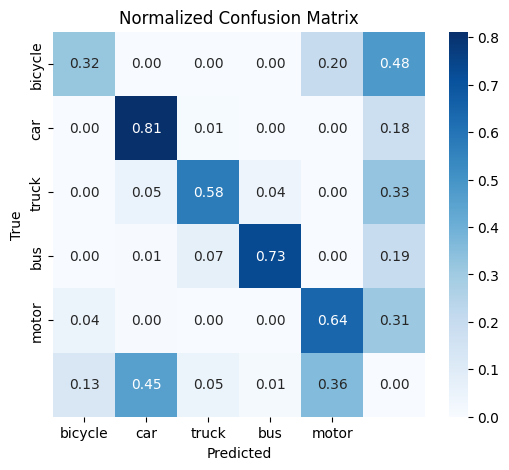

In [ ]:
# Evaluate model trên tập val
import numpy as np


val_results = model.val(data=f"{DATASET_DIR}/data.yaml", split='val')
cm = val_results.confusion_matrix
labels = ['bicycle', 'car', 'truck', 'bus', 'motor']

plt.figure(figsize=(6,5))
sns.heatmap(cm / np.sum(cm, axis=1, keepdims=True), annot=True, fmt=".2f", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
# Dự đoán ảnh mẫu
pred = model.predict(
    source=f"{DATASET_DIR}/val/images",
    conf=0.5,
    save=True,
    project=PROJECT_DIR,
    name="predictions"
)


NameError: name 'model' is not defined

In [ ]:
metrics = {
    "mAP@0.5": df['metrics/mAP50(B)'].iloc[-1],
    "mAP@0.5:0.95": df['metrics/mAP50-95(B)'].iloc[-1],
    "F1": df['metrics/F1(B)'].iloc[-1],
    "Precision": df['metrics/precision(B)'].iloc[-1],
    "Recall": df['metrics/recall(B)'].iloc[-1]
}

print("📊 Final Model Performance:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


NameError: name 'df' is not defined